# Trajectory Optimization for a planar walker

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [20]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource
)
import importlib
import find_throwing_trajectory
importlib.reload(find_throwing_trajectory)
from find_throwing_trajectory import find_throwing_trajectory

meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7007


## Run trajectory optimization to find the optimal trajectory

In [21]:
N = 20
x_guess = np.load("/home/anirudhkailaje/Documents/01_UPenn/02_MEAM5170/03_FinalProject/src/traj.npy")
initial_state = x_guess[:,0]
# final_configuration = np.array([np.pi, 0])
tf = 1.0
distance = 15.0
x_traj, u_traj, prog, _, _ = find_throwing_trajectory(N, initial_state, jumpheight = 1.5, tf=3, jumpheight_tol=5e-2)

optimal cost:  4908009.564939013
x_sol:  [[ 1.81662771e-16  1.98340723e-15 -3.59017047e-14  1.97687739e-14
   1.65378020e-17 -2.95661536e-16  1.36448101e-16  0.00000000e+00
   1.06942607e-11  1.80740527e-11  0.00000000e+00  1.10347261e-11
  -6.29213303e-12 -1.28041968e-11]
 [ 2.67839168e-01  5.43049716e-01 -1.63987257e-02  2.66759660e-01
   6.82500904e-01  0.00000000e+00  2.44922348e-01  1.65405812e+00
   4.69723704e-01 -2.80577993e+00  6.14253016e+00  3.94715932e+00
  -5.54347884e+00 -2.28310356e-01]
 [ 4.28188249e-01  4.88701467e-01  2.67981104e-01 -4.51477136e-01
   7.80000000e-01  0.00000000e+00  3.85832337e-01 -3.96318718e-01
  -2.31318470e+00  3.43893500e+00  1.13313237e+01  1.01965086e+01
  -7.13384003e+00 -1.31452845e+01]
 [-6.63678712e-02  4.58180167e-01 -4.39680180e-01 -4.76664803e-01
  -2.30220949e-01  0.00000000e+00  1.42415279e+00 -2.17836762e+00
   6.44171642e-01 -7.83908798e-01  5.48152031e+00 -1.74299297e+01
  -9.40399875e+00 -1.01932189e+01]
 [-4.74852592e-01  1.286402

## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

7 7 4


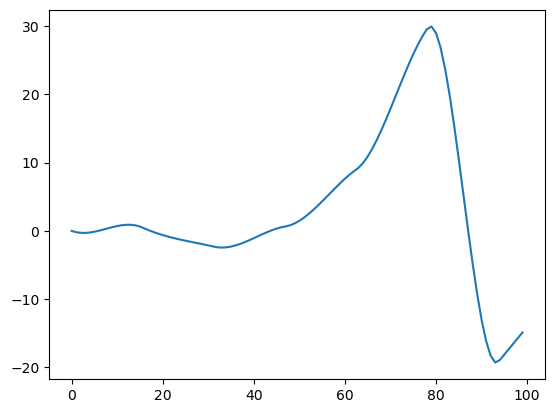

In [25]:
# Create a MultibodyPlant for the arm
file_name = "planar_walker.urdf"
builder = DiagramBuilder()
scene_graph = builder.AddSystem(SceneGraph())
robot = builder.AddSystem(MultibodyPlant(0.0))
robot.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant=robot).AddModels(file_name)
robot.WeldFrames(
            robot.world_frame(),
            robot.GetBodyByName("base").body_frame(),
            RigidTransform.Identity()
)
robot.Finalize()

n_q = robot.num_positions()
n_v = robot.num_velocities()
n_u = robot.num_actuators()
print(n_q, n_v, n_u)

# x_traj_mod = np.zeros((n))
x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(robot))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), robot.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(robot.get_source_id()))

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("diagram")
context = diagram.CreateDefaultContext()
simulator = Simulator(diagram)
simulator.Initialize()
simulator.set_target_realtime_rate(1)
robot_context = diagram.GetMutableSubsystemContext(robot, simulator.get_mutable_context())

timesteps = np.linspace(0, 1.0, 100)
com_pos_list = []
vel_list = []
for t in timesteps:
  x = x_traj.vector_values([t])
  robot.SetPositionsAndVelocities(robot_context, x)
  com_pos = robot.CalcCenterOfMassPositionInWorld(robot_context).ravel()
  com_pos_list.append(com_pos[2])
  vel_list.append(x[8])
  # simulator.AdvanceTo(t)
  # time.sleep(2)

# # Visualize the motion for `n_playback` times
# n_playback = 3
# for i in range(n_playback):
#   # Set up a simulator to run this diagram.
#   simulator = Simulator(diagram)
#   simulator.Initialize()
#   simulator.set_target_realtime_rate(1)
#   simulator.AdvanceTo(tf);
#   time.sleep(2)

fig = plt.figure()
# plt.plot(timesteps, com_pos_list)
plt.plot(vel_list)
plt.show()

In [23]:
x_guess[:, ::(x_guess.shape[1])//15][:,:15].shape

(14, 15)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=71c969e2-d88b-4bfd-96cb-c4ea4f7f9122' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>